# Module import

In [31]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torch.utils.data as data
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'



# Dataset implementation and import


In [2]:
# define directory path
data_dir_path = '/home/yohei/project/cs760/tiny-imagenet-200'

In [5]:
# data formatting (only one time run at the beginning)
def format_val():
    val_dir = data_dir_path + '/val'
    print("Formatting: {}".format(val_dir))
    val_annotations = "{}/val_annotations.txt".format(val_dir)
    val_dict = {}
    with open(val_annotations, 'r') as f:
        for line in f:
            line = line.strip().split()
            assert(len(line) == 6)
            wnind = line[1]
            img_name = line[0]
            boxes = '\t'.join(line[2:])
            if wnind not in val_dict:
                val_dict[wnind] = []
            entries = val_dict[wnind]
            entries.append((img_name, boxes))
    assert(len(val_dict) == 200)
    for wnind, entries in val_dict.items():
        val_wnind_dir = "{}/{}".format(val_dir, wnind)
        val_images_dir = "{}/images".format(val_dir)
        val_wnind_images_dir = "{}/images".format(val_wnind_dir)
        os.mkdir(val_wnind_dir)
        os.mkdir(val_wnind_images_dir)
        wnind_boxes = "{}/{}_boxes.txt".format(val_wnind_dir, wnind)
        f = open(wnind_boxes, "w")
        for img_name, box in entries:
            source = "{}/{}".format(val_images_dir, img_name)
            dst = "{}/{}".format(val_wnind_images_dir, img_name)
            os.system("cp {} {}".format(source, dst))
            f.write(img_name+'\\'+box+'\\'+'n')
        f.close()
    # os.system("rm -rf %s" % val_images_dir)
    #print("Cleaning up: %s" % val_images_dir)
    print("Formatting val done")

In [6]:
# create dataset object
train_dataset = ImageFolder(data_dir_path + '/train')

In [7]:
# Texting label (only one time run at the beginning)
d = {}

f = open(data_dir_path+'/words.txt','r') 
while(1):
    try:
        key, val = f.readline().split("\t")
        d[key] = val[:-1]
    except Exception:
        break

print(len(d))

aa = train_dataset.classes
for i in range(len(aa)):
    train_dataset.classes[i] = d[aa[i]]

82115


In [ ]:
# Check some pictures

In [38]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img)

Label:  stopwatch, stop watch (155)


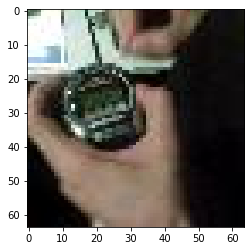

In [42]:
show_example(*train_dataset[77999])

In [22]:
train_dataloader = data.DataLoader(
    train_dataset, batch_size=16, shuffle=True,
    num_workers=2, drop_last=True
)

In [ ]:
train_dataloader

In [ ]:
images, labels = next(iter(train_dataloader))

In [ ]:
len(images)

# Training